In [ ]:
!pip install uv

In [ ]:
!uv pip install "transformers<5" torch scikit-learn pandas numpy rdkit hestia-good

Using Python 3.12.12 environment at: /usr
Audited 7 packages in 124ms


In [ ]:
!wget https://raw.githubusercontent.com/IBM/Hestia-GOOD/refs/heads/main/tests/biogen_logS.csv

--2026-02-09 16:00:06--  https://raw.githubusercontent.com/IBM/Hestia-GOOD/refs/heads/main/tests/biogen_logS.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 188002 (184K) [text/plain]
Saving to: ‘biogen_logS.csv.1’

biogen_logS.csv.1   100%[===================>] 183.60K  --.-KB/s    in 0.01s   

2026-02-09 16:00:06 (12.0 MB/s) - ‘biogen_logS.csv.1’ saved [188002/188002]



In [ ]:
import pandas as pd
from hestia.partition import scaffold

df = pd.read_csv('biogen_logS.csv')
df.head()

,Internal ID,Vendor ID,SMILES,CollectionName,logS
0,Mol1,317714313,CNc1cc(Nc2cccn(-c3ccccn3)c2=O)nn2c(C(=O)N[C@@H...,emolecules,-5.548020
1,Mol2,324056965,CCOc1cc2nn(CCC(C)(C)O)cc2cc1NC(=O)c1cccc(C(F)F)n1,emolecules,-5.071409
2,Mol4,194963090,CC(C)(Oc1ccc(-c2cnc(N)c(-c3ccc(Cl)cc3)c2)cc1)C...,emolecules,-3.925969
3,Mol6,316230505,CC#CC(=O)N[C@H]1CCCN(c2c(F)cc(C(N)=O)c3[nH]c(C...,emolecules,-4.535280
4,Mol9,EN300-97039,C=CC(=O)N1CCC[C@@H](n2nc(-c3ccc(Oc4ccccc4)cc3)...,enamineBB_pmc,-4.709963


In [ ]:
parts = scaffold(df, field_name='SMILES',
                 label_name='logS')
train_df = df.iloc[parts[0], :]
test_df = df.iloc[parts[1], :]
valid_df = df.iloc[parts[2], :]


In [ ]:
train_df.head()

,Internal ID,Vendor ID,SMILES,CollectionName,logS
1353,Mol1432,44388898,N#Cc1cccc(CN2CCOC[C@H](Oc3ccccc3)C2)c1,emolecules,-3.766043
1372,Mol1451,29912859,N#Cc1ccc2nc([C@H]3CCN(C4CCC4)C3)[nH]c2c1,emolecules,-3.724746
1370,Mol1449,29912873,CC(C)CN1CC[C@H](c2nc3ccc(C#N)cc3[nH]2)C1,emolecules,-3.864058
1369,Mol1448,30492932,Cc1ccc(-c2nnc([C@H]3CCN(Cc4cc5ccccc5o4)C3)o2)cc1,emolecules,-4.354216
1367,Mol1446,35754185,COc1cccc(CN(C)c2ncnc3c2CN(C)CC3)c1,emolecules,-3.713383


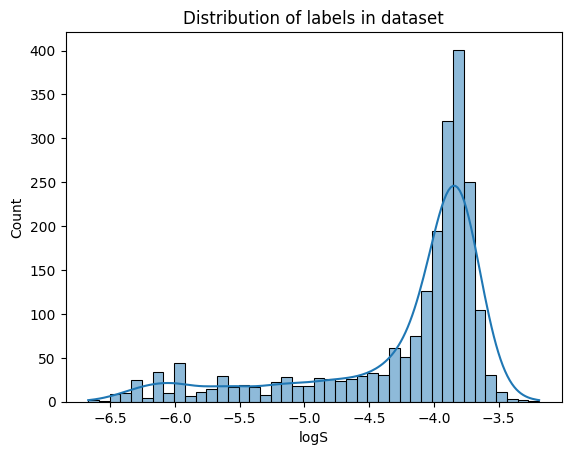

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(train_df.logS, kde=True)
plt.title("Distribution of labels in dataset")
plt.show()

# Chemical Language Models for molecular representation

We are going to use the transformers library to get the models that we need and control them.

There are two models that I would recommend using, but if you find any other models and want to try them feel free.

- Molformer-XL: [ibm/MoLFormer-XL-both-10pct](https://huggingface.co/ibm-research/MoLFormer-XL-both-10pct)
- ChemBERTa-2: [DeepChem/ChemBERTa-77M-MLM](https://huggingface.co/DeepChem/ChemBERTa-77M-MLM)



In [ ]:
model_name : str = "<introduce model name from above>"
model_name = "ibm/MolFormer-XL-both-10pct"

In [ ]:
# Model loading
from transformers import AutoModel, AutoTokenizer

model = AutoModel.from_pretrained(model_name, deterministic_eval=True, trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
max_length = ""
truncation = ""
padding    = ""

max_length = 128
truncation = True

tokens = tokenizer(df['SMILES'].tolist(),
                   max_length=max_length,
                   truncation=truncation,
                   padding=True)

In [ ]:
from itertools import batched
import torch

inputs = tokens['input_ids']
attention_mask = tokens['attention_mask']

for batch in batched(range(len(inputs)), 32):
    batch_inputs = [inputs[i] for i in batch]
    batch_attention_mask = [attention_mask[i] for i in batch]
    rep = model(input_ids=torch.tensor(batch_inputs),
                attention_mask=torch.tensor(batch_attention_mask))
    print(rep)
    break


BaseModelOutputWithPooling(last_hidden_state=tensor([[[-0.9261, -0.2855, -1.5194,  ..., -0.7175, -0.5911,  1.5017],
         [-1.1154, -0.1933, -0.4022,  ..., -0.3257, -0.2333,  0.8552],
         [-0.8835, -0.4456,  1.3984,  ..., -0.2741,  0.2911,  1.5786],
         ...,
         [-0.7799, -0.1225, -1.5200,  ..., -0.7338, -0.6347,  1.5996],
         [-0.7837, -0.2079, -1.5370,  ..., -0.7541, -0.6226,  1.6168],
         [-0.8304, -0.2880, -1.5450,  ..., -0.8683, -0.6335,  1.6197]],

        [[-0.4897, -0.7897, -1.6071,  ...,  0.0596, -0.6353,  0.7690],
         [-0.7317,  0.4614,  0.0204,  ...,  0.3946,  0.0655,  0.9864],
         [-0.2665, -0.4183,  0.7233,  ...,  0.7190,  0.8971,  0.8371],
         ...,
         [-0.2595, -0.7461, -1.5317,  ..., -0.1976, -0.6497,  0.6933],
         [-0.3512, -0.7037, -1.4135,  ..., -0.1102, -0.6986,  0.7062],
         [-0.4056, -0.6357, -1.3682,  ..., -0.1587, -0.7035,  0.7642]],

        [[-0.6942,  0.3829, -1.0933,  ...,  0.6881,  0.3624,  0.9059],
